<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:36px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Deep Learning for Actuaries</b></div>

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Three interpretable frameworks for an actuarial context</b></div>

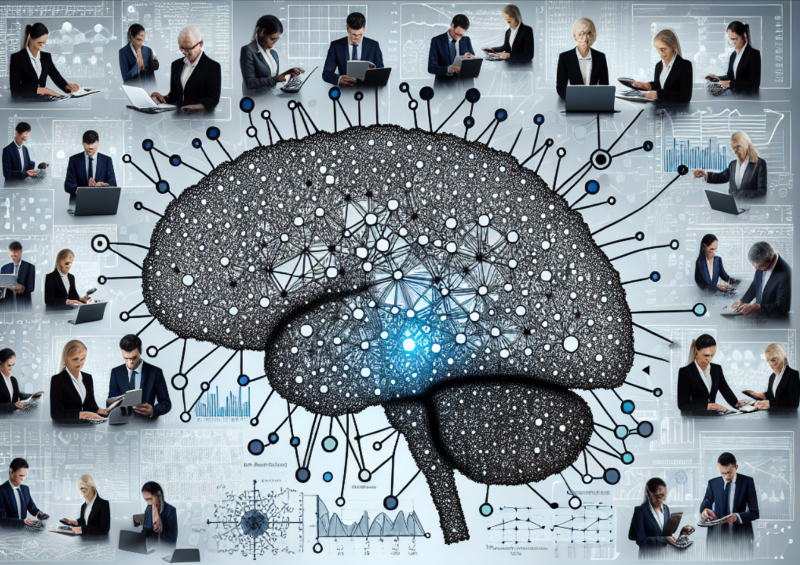  

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Introduction</b></div>

<div style="text-align: justify;">Recent breakthroughs in artificial intelligence (AI) have been largely driven by neural networks, particularly deep learning frameworks. These techniques have revolutionized fields such as image recognition, natural language processing, and predictive analytics.
However, it can be difficult to apply neural networks in actuarial settings. First, neural networks are often considered "black boxes" because of their complex structure with thousands of parameters. Actuaries usually produce rating structures that clearly show how premiums and risk behave over different variables, as transparency and interpretability are crucial in actuarial work. Neural networks though only return a single prediction which makes it much more difficult to interpret model results and provide explanations to stakeholders. Second, most actuarial datasets have a tabular structure, consisting of structured numerical and categorical variables. It has been shown that neural networks and deep learning mainly excel in tasks such as image recognition and language processing <reference>. On tabular data, traditional models such as Generalized Linear Models (GLM) or tree-based models (e.g. Random Forest, GBM) usually perform better.
Recognizing these challenges, deep learning frameworks suited for actuarial problems and tabular data have been developed in the academic community. In this article, we discuss three of these frameworks: the Combined Actuarial Neural Network (CANN), LocalGLMNet and TabNet. We briefly explain the workings of these models and the pros and cons of each method.
</div>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Table of Contents</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
<a id="TOC"></a>
    
* [Code setup](#code_setup)
* [Import libraries and load data](#import)
* [Data Preprocessing](#data_preprocessing)
* [Model Evaluation Functions](#model_evaluation)
* [The GLM benchmark model](#glm)
* [The Combined Actuarial Neural Network](#cann)
* [LocalGLMNet](#localglm)
* [TabNet](#tabnet)
* [Results evaluation](#results)
* [References](#ref)
* [Related Projects](#rel)

<a id="code_setup"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Code setup</b></div>

The python version used for this notebook is 3.10.x

We recommend to create a dedicated Conda environment for this notebook. See the example terminal commands:

Along with the python version, please install:

- Create a new conda environment named 'dl-env' with Python 3.10:
*conda create -n dl-env python=3.10*

- Activate the new environment:
*conda activate dl-env*

- Install the required packages:
*conda install pandas scikit-learn matplotlib numpy*

- Install TensorFlow using pip:
*pip install tensorflow*

- Install PyTorch and torchvision for CPU only:
*conda install pytorch torchvision torchaudio cpuonly -c pytorch*

- and all other remaining packages below

<a id="import"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Import libraries and load data</b></div>

In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_poisson_deviance
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Nadam

import torch
from pytorch_tabnet.tab_model import TabNetRegressor

For simplicity and transparency, we use an open source dataset with a portfolio of car insurance policies and claims. The dataset can be loaded from the repository or it can be found on Kaggle (https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq). This is a well-known and often used dataset for modelling. This provides transparency as results can be benchmarked to other work.

In [2]:
# Load the dataset (replace with your actual file path)
#data = pd.read_csv('C:/Users/R0626499/OneDrive - Allianz/Documents/Bart/Actuaris/DL_for_Actuaries/data/freMTPL2freq.csv')
data = pd.read_csv('C:/Users/bart_/Documents/git_repo/DL_for_Actuaries/data/freMTPL2freq.csv')

# Inspect the dataset
data.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [3]:
data.shape

(678013, 12)

<a id="data_preprocessing"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Data Preprocessing</b></div>

The preprocessing is largely based on Richman & Wüthrich (2023), meaning that data in the tails will be right-censored. Furthermore, the Area feature is encoded to be treated as a continuous feature.

The dataset consists of a mix of numerical and categorical features. Many machine learning models cannot process categorical features in their raw format, so we need to One-Hot encode the categorical features. Furthermore, it is common the standardize numerical data before training. Both the standardization and onehot encoding are applied below in a preprocessing pipeline. 

Another important step is the creation of a train and test sample, a 90/10 split will be used.

In [4]:
# Some data preparation
data['Exposure'] = 1 # Set exposure to 1 for simplicity
exposure = data['Exposure']

# Right-censor the data to deal with low observations
data['VehAge'] = data['VehAge'].clip(upper=20)
data['DrivAge'] = data['DrivAge'].clip(upper=90)
data['BonusMalus'] = data['BonusMalus'].clip(upper=150)

# Encode Area as continuous
area_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
data['Area'] = data['Area'].map(area_mapping)

# Remove missing values
data = data.dropna()

# Preprocess the Dataset
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus','Area']
categorical_features = ['VehBrand', 'Region','VehGas']

y = data['ClaimNb']
X = data.drop(columns=['ClaimNb', 'Exposure', 'IDpol'], axis=1)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Split the dataset including the exposure
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.1, random_state=42
)

# Apply the preprocessing pipeline
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get categorical feature names from OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()

# Combine numerical and encoded categorical feature names
feature_names = numerical_features + cat_feature_names

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Model Evaluation Functions</b></div>

In this section we will define functions that will evaluate the model performance. As evaluation metrics we chose RMSE, mean absolute error (MAE) and Poisson deviance as they are commonly used for model performance assessment. Furthermore, we define functions for graphical evaluation with quantile plots (showing actuals vs predictions) and double lift charts for model comparison. 

In [5]:
# Dictionary to store evaluation results
model_results = {}

# Function to calculate model performance metrics and store them in a dict
def evaluate_model(model_name, y_true, y_pred):
    rmse = float(root_mean_squared_error(y_true, y_pred))  # Convert to float
    mae = float(mean_absolute_error(y_true, y_pred))  # Convert to float
    poisson_dev = float(mean_poisson_deviance(y_true, y_pred))  # Convert to float

    # Store results in the dictionary
    model_results[model_name] = {
        "RMSE": rmse,
        "MAE": mae,
        "Poisson Deviance": poisson_dev
    }

    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


In [6]:
def quantile_plot(model_name,y_true, y_pred, num_bins=10):
    # Create a DataFrame with true and predicted values
    df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

    # Create groups
    df['Decile'] = pd.qcut(df['Predicted'], q=num_bins, labels=False, duplicates='drop')

    # Calculate average actual and predicted values for each decile
    decile_summary = df.groupby('Decile').agg({'Actual': 'mean', 'Predicted': 'mean'}).reset_index()

    plt.figure(figsize=(7, 4))
    plt.plot(decile_summary['Decile'], decile_summary['Actual'], marker='o', label='Actual')
    plt.plot(decile_summary['Decile'], decile_summary['Predicted'], marker='x', label='Predicted')
    plt.xlabel('Decile')
    plt.ylabel('Average Value')
    plt.title(f"Actual vs predicted: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def double_lift_chart(model_name1, model_name2, y_true, y_pred1, y_pred2, exposure, num_bins=10):
    # Create a DataFrame with actual, predicted values, and exposure
    df = pd.DataFrame({'Actual': y_true, 
                       'Predicted1': y_pred1, 
                       'Predicted2': y_pred2, 
                       'Exposure': exposure})
    
    # Compute ratio of model prediction 2 to model prediction 1
    df['Ratio'] = df['Predicted2'] / df['Predicted1']
    
    # Sort by the ratio
    df = df.sort_values(by='Ratio')

    # Compute cumulative exposure to create equal exposure bins
    df['Cumulative_Exposure'] = df['Exposure'].cumsum()
    total_exposure = df['Exposure'].sum()
    
    # Assign deciles based on equal exposure
    df['Decile'] = pd.cut(df['Cumulative_Exposure'], 
                          bins=np.linspace(0, total_exposure, num_bins+1), 
                          labels=False, 
                          include_lowest=True)

    # Aggregate by decile
    decile_summary = df.groupby('Decile').agg({'Actual': 'mean', 
                                               'Predicted1': 'mean', 
                                               'Predicted2': 'mean'}).reset_index()

    # Indexing: Divide by the overall mean
    decile_summary['Actual'] /= df['Actual'].mean()
    decile_summary['Predicted1'] /= df['Predicted1'].mean()
    decile_summary['Predicted2'] /= df['Predicted2'].mean()

    # Plot double lift chart
    plt.figure(figsize=(7, 4))
    plt.plot(decile_summary['Decile'], decile_summary['Actual'], marker='o', label='Actual', linestyle='-')
    plt.plot(decile_summary['Decile'], decile_summary['Predicted1'], marker='x', label=model_name1, linestyle='--')
    plt.plot(decile_summary['Decile'], decile_summary['Predicted2'], marker='s', label=model_name2, linestyle='-.')
    
    plt.xlabel('Decile (Sorted by Ratio of Model 2 to Model 1)')
    plt.ylabel('Indexed Value')
    plt.title(f"Double Lift Chart: {model_name1} vs {model_name2}")
    plt.legend()
    plt.grid(True)
    plt.show()

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>The GLM benchmark model</b></div>

As a first step and benchmark we will now fit a GLM. As we are predicting claim frequency (count) we will use a Poisson distribution. For this we employ a PoissonRegressor from Scikit learn's linear model library. The only parameter that is defined in the Poisson Regressor is 'alpha', which indicates the regularization strength (the extent to which L2 penalty terms are applied). For this simple implementation we will go with traditional, unpenalized GLMs (alpha=0).  

In [8]:
# Instantiate the Poisson regressor
glm = PoissonRegressor(alpha=0)
glm.fit(X_train, y_train)

PoissonRegressor(alpha=0)

Now the GLM is fitted, we can inspect the features and coefficients:

In [9]:
# Get the coefficients from the model
coefficients = glm.coef_

# Display
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False).drop(columns="Abs_Coefficient")
print(coef_df)

           Feature  Coefficient
19      Region_R23    -0.310495
28      Region_R53     0.291609
3       BonusMalus     0.280360
31      Region_R73    -0.235607
20      Region_R24     0.233436
34      Region_R83    -0.208539
21      Region_R25     0.200424
23      Region_R31    -0.185984
33      Region_R82     0.183471
2          DrivAge     0.179089
30      Region_R72    -0.166583
1           VehAge    -0.165366
32      Region_R74     0.150778
35      Region_R91    -0.134827
14     VehBrand_B5     0.112422
27      Region_R52     0.111502
29      Region_R54     0.098630
38   VehGas_Diesel    -0.091885
10    VehBrand_B14    -0.083858
6     VehBrand_B10    -0.069260
24      Region_R41    -0.065605
18      Region_R22     0.060355
8     VehBrand_B12    -0.056526
36      Region_R93    -0.053081
4             Area     0.049917
26      Region_R43    -0.048182
25      Region_R42     0.046580
22      Region_R26    -0.043340
15     VehBrand_B6    -0.035368
5      VehBrand_B1     0.030330
11     V

For evaluation, we first need to make predictions on our test sample. When predictions on X_test are available, we can call the evaluation function and plot the double lift chart:

In [10]:
# Get GLM predictions
glm_preds_train = glm.predict(X_train)
glm_preds_test = glm.predict(X_test)

In [11]:
# Evaluate GLM
evaluate_model("GLM", y_test, glm_preds_test)

GLM - RMSE: 0.2335, MAE: 0.0991, Poisson Deviance: 0.3080


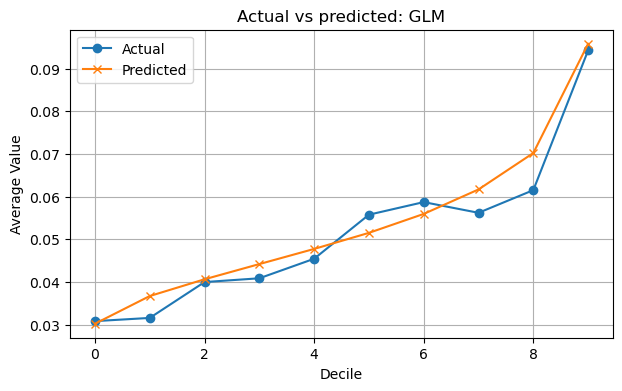

In [12]:
quantile_plot("GLM",y_test, glm_preds_test)

<a id="cann"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>The Combined Actuarial Neural Network</b></div>

**A brief intro to Neural Networks**

A neural network is a model inspired by the structure of the human brain. It consists of multiple layers of interconnected nodes (neurons) that process the data and aim to learn the relationships in the data. The three main components of a neural network are:

•	**Input layer**: This is the layer that processes the input data. Each neuron in this layer represents a feature in the dataset (e.g., policyholder age, claim history, insured amount). 

•	**Hidden layers**: The hidden layers perform complex transformations on the data. Each neuron in a hidden layer takes inputs from the previous layer, applies a transformation and weighting, and then passes the result through an activation function. 

•	**Output layer**: The output layer produces the final prediction for the problem at hand. 

Neural networks are usually trained ‘supervised’, meaning that we give the true labels of our problem to the model. So in a classification problem for example, we will provide the true labels which the model can compare to the predicted labels in a loss function. The neural network then learns by adjusting the weights of connections between the neurons to optimize the loss function. 

**The Combined Actuarial Neural Network (CANN)**

The CANN model, as proposed by Wüthrich & Merz (2019) combines a GLM with a neural network. By using the GLM predictions, the neural network part aims to capture additional patterns that were not captured by the GLM. In the output layer, the final CANN prediction is then obtained by combining the GLM prediction (that arrives via a ‘skip connection’) with the neural network prediction. In this way, CANN retains the interpretability of GLMs while improving predictive performance.

In [13]:
# Define the GLM predictions for the Skip-layer of CANN
log_glm_preds_train = np.log(glm_preds_train)
log_glm_preds_test = np.log(glm_preds_test)

For the architecture of the neural network part, we will largely follow Wüthrich & Merz (2023). The input layer gets the number of neurons equal to the size of the feature set. Next, three hidden, fully-connected layers are added with ReLu activation. We also experimented with Tanh activation but this did not change results significantly. 

Next the skip connection is added, so that the original GLM predictions arrive in the output layer, jointly with the neural network predictions. The output layer will then produce the final prediction through exponential activation.

Model parameters, such as the number of layers, layer-size, learning rate and batch-size can potentially be tuned, but for simplicity we will continue without hyperparameter tuning. We will now define the architecture of the model:

In [14]:
# Define Input Layer
input_layer = Input(shape=(X_train.shape[1],), name="Design")

# Neural Network layers
hidden1 = layers.Dense(128, activation="relu", name="hidden1")(input_layer)
hidden2 = layers.Dense(64, activation="relu", name="hidden2")(hidden1)
hidden3 = layers.Dense(32, activation="relu", name="hidden3")(hidden2)
nn_output = layers.Dense(1, activation=None, name="Network")(hidden3)

# GLM Skip connection
glm_input = Input(shape=(1,), name="LogGLM")

# Combine GLM and Neural Network Outputs
combined_output = layers.Add(name="Add")([nn_output, glm_input])

# Final Output Layer with exponential activation
final_output = layers.Dense(1, activation="exponential", name="Response")(combined_output)

# Create the model
cann_model = Model(inputs=[input_layer, glm_input], outputs=final_output)
cann_model.get_layer("Response").trainable = False
optimizer = Nadam(learning_rate=0.005)
cann_model.compile(optimizer=optimizer, loss="poisson")
cann_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Design (InputLayer) │ (None, 40)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden1 (Dense)     │ (None, 128)       │      5,248 │ Design[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden2 (Dense)     │ (None, 64)        │      8,256 │ hidden1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden3 (Dense)     │ (None, 32)        │      2,080 │ hidden2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Network (Dense)     │ (None, 1)         │         33 │ hidden3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LogGLM (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Add (Add)           │ (None, 1)         │          0 │ Network[0][0],    │
│                     │                   │            │ LogGLM[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Response (Dense)    │ (None, 1)         │          2 │ Add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,619 (61.01 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 2 (8.00 B)

After defining the model we can train the model below. Many studies train with hundreds of epochs, from the plot below we have concluded that 15-20 epochs are enough for optimal results. More epochs result in overfitting.

In [15]:
# Train the CANN model
history_cann = cann_model.fit(
    [X_train, log_glm_preds_train],
    y_train,
    epochs=15,
    batch_size=4000,
    validation_data=([X_test, log_glm_preds_test], y_test)
)

Epoch 1/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4829 - val_loss: 0.2013
Epoch 2/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2059 - val_loss: 0.2015
Epoch 3/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2057 - val_loss: 0.2015
Epoch 4/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2066 - val_loss: 0.2010
Epoch 5/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2056 - val_loss: 0.2011
Epoch 6/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2058 - val_loss: 0.2007
Epoch 7/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2059 - val_loss: 0.2005
Epoch 8/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2054 - val_loss: 0.1999
Epoch 9/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2044 - val_loss: 0.1994
Epoch 10/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2047 - val_loss: 0.1994
Epoch 11/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2047 - val_loss: 0.1987
Epoch 12/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

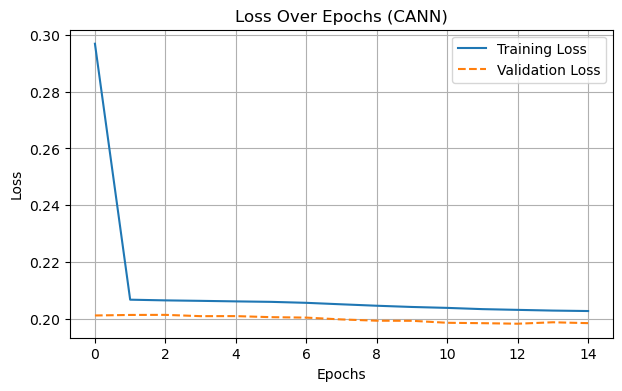

In [16]:
# Plot the loss over the epochs
plt.figure(figsize=(7, 4))
plt.plot(history_cann.history['loss'], label='Training Loss')
plt.plot(history_cann.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss Over Epochs (CANN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Let us now evaluate the performance of the CANN model. We can print model metrics and compare predictions vs actuals:

In [17]:
# Evaluate CANN
cann_preds_test = cann_model.predict([X_test, log_glm_preds_test])
cann_preds_test = np.maximum(cann_preds_test, 1e-6)  
evaluate_model("CANN", y_test, cann_preds_test)

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
CANN - RMSE: 0.2325, MAE: 0.0971, Poisson Deviance: 0.3021


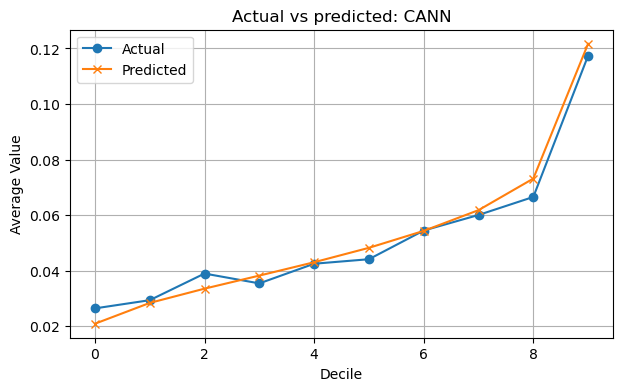

In [18]:
cann_preds_test_adj = np.ravel(cann_preds_test) 
quantile_plot("CANN",y_test, cann_preds_test_adj)

Now also compare the CANN predictions to the GLM predictions, by calling the double lift chart function:

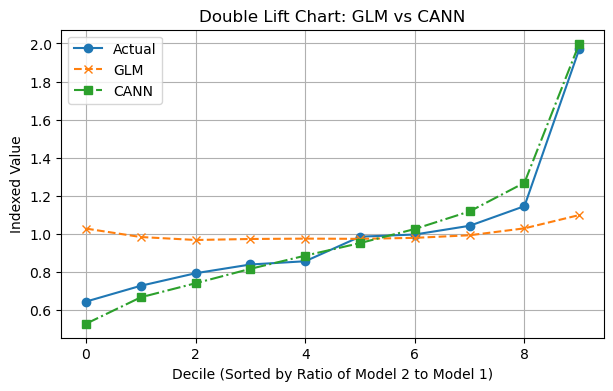

In [19]:
double_lift_chart("GLM", "CANN", y_test, glm_preds_test, cann_preds_test_adj, exposure_test, num_bins=10)

Now let's get some more insight into the differences in prediction. For this, we need to inverse the transformations done in the preproccesing step, to obtain a test set with original features. This enhances readability. 

Next, we can plot the predictions of the GLM and CANN per feature to assess how predictions vary and what is essentially the adjustment done by the neural network.

In [20]:
# Inverse transform the scaled data
scaler = preprocessor.named_transformers_['num']
X_test_dense = X_test.toarray() if isinstance(X_test, csr_matrix) else X_test
X_test_inv_scaled = scaler.inverse_transform(X_test_dense[:, :len(numerical_features)])

# Reversing the OneHotEncoder
encoder = preprocessor.named_transformers_['cat']
cat_feature_names = encoder.get_feature_names_out(categorical_features)
X_test_inv_categorized = encoder.inverse_transform(X_test_dense[:, len(numerical_features):])

# Combine the numerical and categorical back to a dataframe
X_test_inv = np.hstack([X_test_inv_scaled, X_test_inv_categorized])
X_test_inv_df = pd.DataFrame(X_test_inv, columns=numerical_features + categorical_features)

# Add predictions to the dataframe
X_test_inv_df['GLM_Predictions'] = glm_preds_test.ravel()
X_test_inv_df['CANN_Predictions'] = cann_preds_test.ravel()

In [21]:
def plot_feature_comparisons(features, X_test_inv_df, model1_preds, model2_preds, model1_label="Model 1", model2_label="Model 2"):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, feature_name in enumerate(features):
        plot_data = X_test_inv_df.groupby(feature_name)[[model1_preds, model2_preds]].mean().reset_index()
        
        ax = axes[i]
        ax.plot(plot_data[feature_name], plot_data[model1_preds], label=model1_label, linestyle="--", marker="o")
        ax.plot(plot_data[feature_name], plot_data[model2_preds], label=model2_label, linestyle="-", marker="s")
        
        # Fill the area between the two model predictions
        ax.fill_between(plot_data[feature_name], plot_data[model1_preds], plot_data[model2_preds],
                        color="salmon", alpha=0.5, label="NN adjustment")
        
        ax.set_xlabel(feature_name)
        ax.set_ylabel("Average Predicted Values")
        ax.set_title(f"{model1_label} and {model2_label} Predictions by {feature_name}")
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

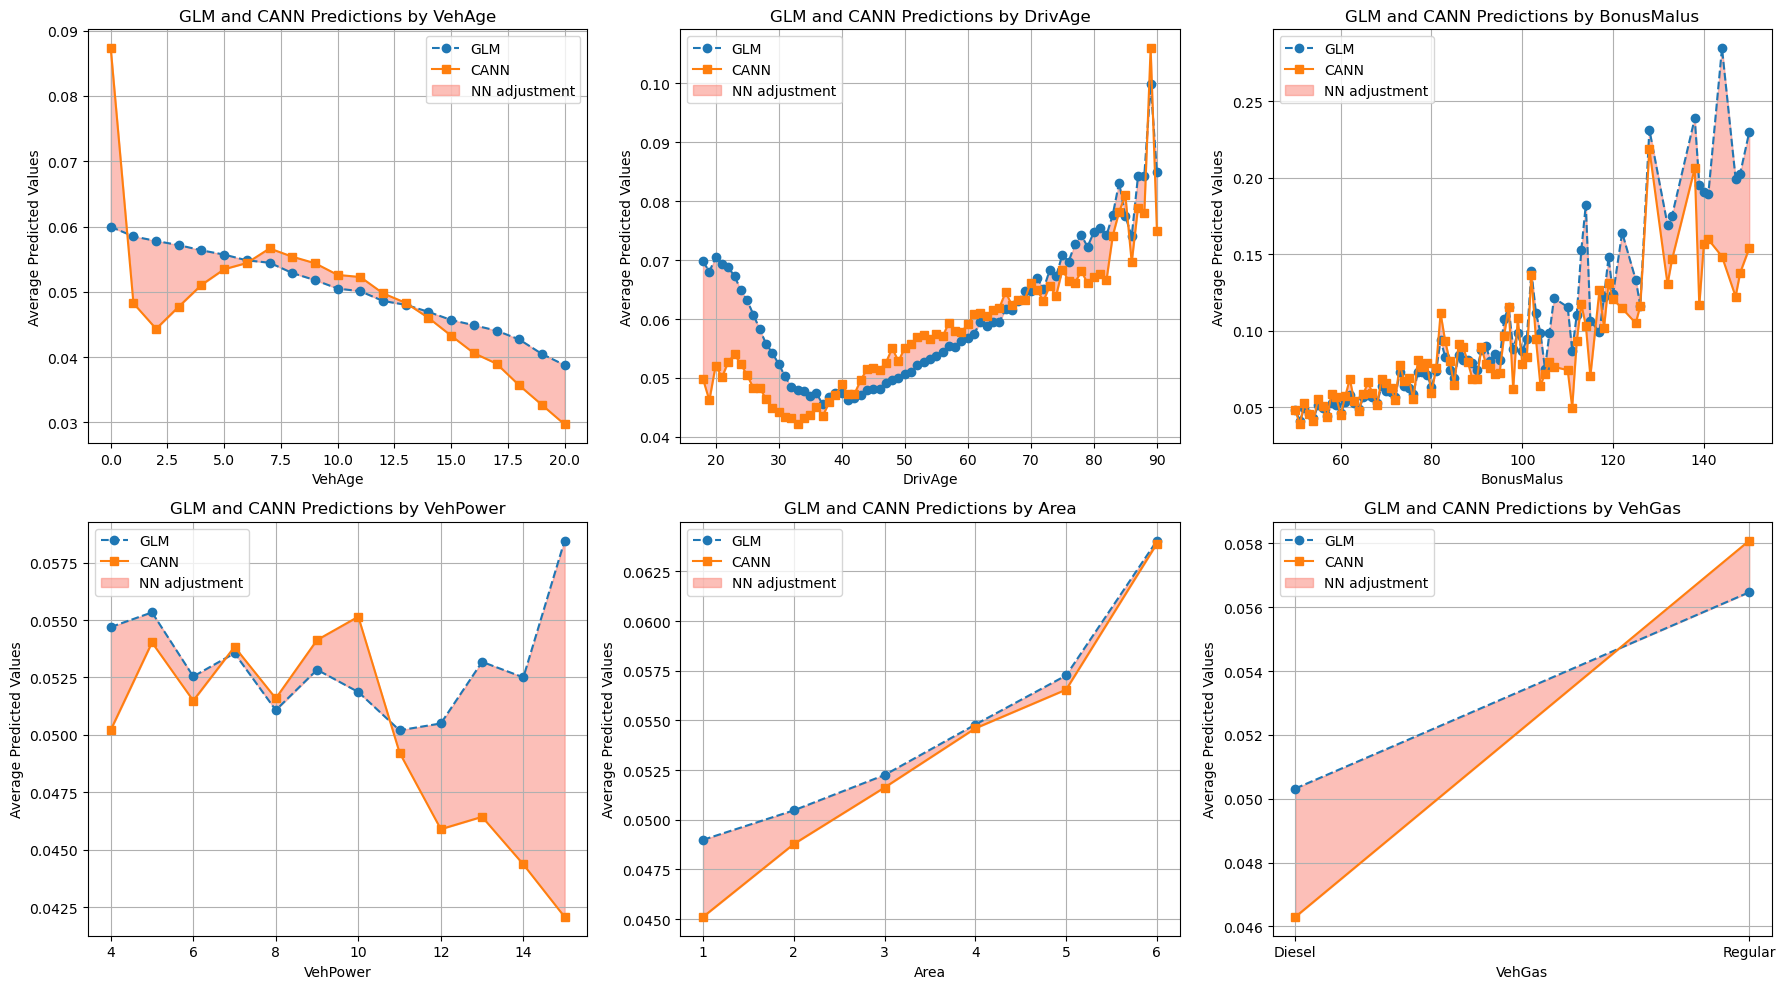

In [22]:
plot_feature_comparisons(['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas'], X_test_inv_df, 'GLM_Predictions', 'CANN_Predictions', model1_label="GLM", model2_label="CANN")

<a id="localglm"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>LocalGLMNet</b></div>

LocalGLMNet is another hybrid model designed for actuarial applications that was developed by Richman & Wüthrich (2023). Instead of producing a single set of fixed coefficients like a traditional GLM, it learns for each data record a distribution of local coefficients. For this the model uses attention weights, which are used in a neural network to determine the importance of different parts of the input data. By multiplying the attention weights with the input data, the structure of a GLM is maintained while allowing for more complex interactions. Furthermore, the attention weights can be used to generate local explanations that can help actuaries to explain results.

For the architecture of the neural network part, we will largely follow Richman & Wüthrich (2023). The input layer gets the number of neurons equal to the size of the feature set. Next, three hidden, fully-connected layers are added with hyperbolic tangent (Tanh) activation. These are followed by another layer with size equal to the size of the feature set. This layer aims to provide the attention weights of the network. In a neural network training, attention weights determine the importance of different parts of the input data. They basically help the model in focusing on the most relevant elements. In the LocalGLMNet framework, these attention weights are then multiplied with the input features to get to the final predictions.

Model parameters, such as the number of layers, layer-size, learning rate and batch-size can potentially be tuned, but for simplicity we will continue without hyperparameter tuning. We will now define the architecture of the model:

In [23]:
# Define Input Layer
input_layer = Input(shape=(X_train.shape[1],), dtype='float32', name='Design')
exposure = Input(shape=(1,), dtype='float32', name='Exposure')

# Neural Network Layers (Attention Mechanism)
hidden1 = layers.Dense(20, activation='tanh', name='FNLayer1')(input_layer)
hidden2 = layers.Dense(15, activation='tanh', name='FNLayer2')(hidden1)
hidden3 = layers.Dense(10, activation='tanh', name='FNLayer3')(hidden2)
attention = layers.Dense(X_train.shape[1], activation='linear', name='Attention')(hidden3)

# Skip Connection: Element-wise multiplication of input_layer and attention
skip_connection = layers.Multiply(name='SkipConnection')([input_layer, attention])

# Sum along the feature dimension (axis=1) to get a single value per sample
localglm = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True), name='LocalGLM')(skip_connection)

# Apply final transformation
balance = layers.Dense(1, activation='exponential', name='Balance')(localglm)

# Final Response Calculation (Multiply with Exposure)
final_output = layers.Multiply(name='Multiply')([balance, exposure])

# Create and compile model
localglm_model = Model(inputs=[input_layer, exposure], outputs=[final_output], name='LocalGLMNet')
optimizer = Nadam(learning_rate=0.005)
localglm_model.compile(optimizer=optimizer, loss="poisson")
localglm_model.summary()

Model: "LocalGLMNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Design (InputLayer) │ (None, 40)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer1 (Dense)    │ (None, 20)        │        820 │ Design[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer2 (Dense)    │ (None, 15)        │        315 │ FNLayer1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer3 (Dense)    │ (None, 10)        │        160 │ FNLayer2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention (Dense)   │ (None, 40)        │        440 │ FNLayer3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SkipConnection      │ (None, 40)        │          0 │ Design[0][0],     │
│ (Multiply)          │                   │            │ Attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LocalGLM (Lambda)   │ (None, 1)         │          0 │ SkipConnection[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Balance (Dense)     │ (None, 1)         │          2 │ LocalGLM[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Exposure            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Multiply (Multiply) │ (None, 1)         │          0 │ Balance[0][0],    │
│                     │                   │            │ Exposure[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,737 (6.79 KB)

 Trainable params: 1,737 (6.79 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the LocalGLM model
history_localglm = localglm_model.fit(
    [X_train, np.ones_like(y_train)], 
    y_train, 
    epochs=20, 
    batch_size=4000,
    validation_data=([X_test, np.ones_like(y_test)], y_test))

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4686 - val_loss: 0.2026
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2074 - val_loss: 0.2012
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2060 - val_loss: 0.2012
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2064 - val_loss: 0.2005
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2052 - val_loss: 0.1996
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2050 - val_loss: 0.1988
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2035 - val_loss: 0.1986
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2005 - val_loss: 0.1990
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2028 - val_loss: 0.1982
Epoch 10/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2010 - val_loss: 0.1984
Epoch 11/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2014 - val_loss: 0.1980
Epoch 12/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

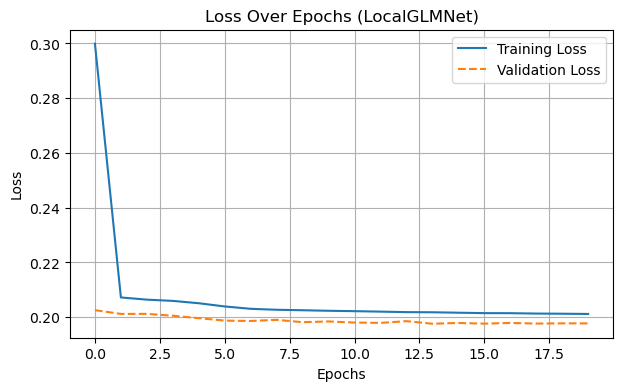

In [25]:
# Plot the loss over the epochs
plt.figure(figsize=(7, 4))
plt.plot(history_localglm.history['loss'], label='Training Loss')
plt.plot(history_localglm.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss Over Epochs (LocalGLMNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The LocalGLMNet is trained, so we can evaluate the performance by calling the evaluation and plot functions:

In [26]:
# Evaluate LocalGLM
localglm_preds_test = localglm_model.predict([X_test, np.ones_like(y_test)])
evaluate_model("LocalGLMNet", y_test, localglm_preds_test)

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
LocalGLMNet - RMSE: 0.2321, MAE: 0.0995, Poisson Deviance: 0.3004


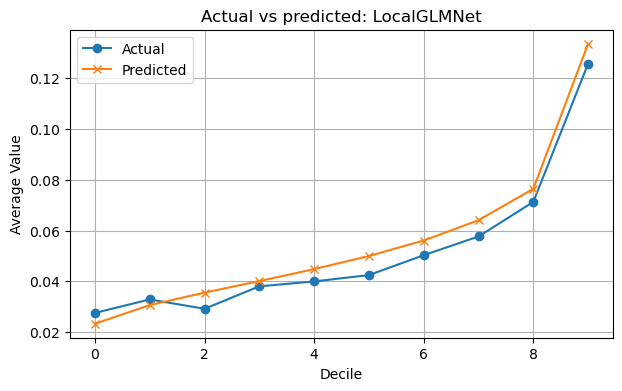

In [27]:
localglm_preds_test = np.ravel(localglm_preds_test) 
quantile_plot("LocalGLMNet",y_test, localglm_preds_test)

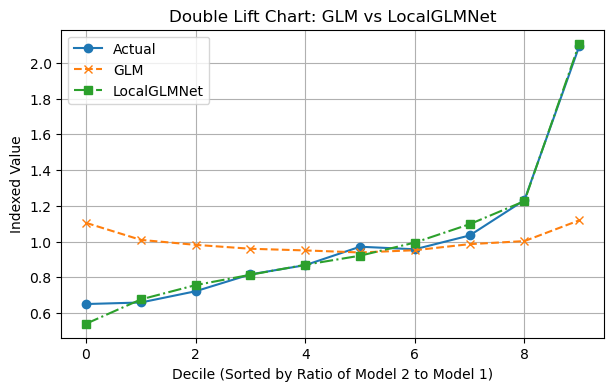

In [28]:
double_lift_chart("GLM", "LocalGLMNet", y_test, glm_preds_test, localglm_preds_test, exposure_test, num_bins=10)

*Alternative implementation of LocalGLM with Pytorch (@Garry I think the Keras implementation above is better)*

In [29]:
# # Build the LocalGLMNet Model
# class LocalGLMNet(nn.Module):
#     def __init__(self, input_size, hidden_layer_sizes):
#         super(LocalGLMNet, self).__init__()
#         self.hidden_layers = nn.ModuleList(
#             [nn.Linear(input_size, hidden_layer_sizes[0])]
#         )
#         self.hidden_layers.extend(
#             [
#                 nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1])
#                 for i in range(len(hidden_layer_sizes) - 1)
#             ]
#         )
#         self.last_hidden_layer = nn.Linear(hidden_layer_sizes[-1], input_size)
#         self.output_layer = nn.Linear(1, 1)
#         self.activation = nn.Tanh()
#         self.inverse_link = torch.exp

#     def forward(self, features, exposure=None, attentions=False):
#         x = features
#         for layer in self.hidden_layers:
#             x = self.activation(layer(x))
#         x = self.last_hidden_layer(x)
#         if attentions:
#             return x
#         skip_connection = torch.einsum("ij,ij->i", x, features).unsqueeze(1)
#         x = self.output_layer(skip_connection)
#         x = self.inverse_link(x)
#         if exposure is None:
#             exposure = torch.ones_like(x, device=features.device)
#         x = x * exposure
#         return x

# def train_model(X, v, y, device):
#     localglmnet = NeuralNetRegressor(
#         module=LocalGLMNet,
#         max_epochs=20,
#         criterion=nn.PoissonNLLLoss,
#         criterion__log_input=False,
#         module__input_size=X.shape[1],
#         module__hidden_layer_sizes=[128, 64, 32],
#         optimizer=NAdam,
#         lr=0.005,
#         batch_size=4000,
#         device=device,
#     )

#     X_dict = {"features": X, "exposure": v}
#     localglmnet.fit(X_dict, y)
#     return localglmnet

In [30]:
# Convert data to PyTorch tensors
# X_train_torch = torch.FloatTensor(X_train.toarray())
# y_train_torch = torch.FloatTensor(y_train.values)
# X_test_torch = torch.FloatTensor(X_test.toarray())
# y_test_torch = torch.FloatTensor(y_test.values)

In [31]:
# Train the LocalGLMNet
#trained_model = train_model(X_train_torch, np.ones_like(y_train_torch), y_train_torch, device='cpu')

In [32]:
# # Evaluate LocalGLMNet
# localglmnet_preds_test = trained_model.predict(X_test_torch)
# evaluate_model("LocalGLMNet", y_test, localglmnet_preds_test)

A new element of LocalGLMNet compared to CANN are the attention weights. As the attention weights help the neural network to focus on the most important elements, they can be used to inspect variable or feature importance. A common approach is to determine variable importance by aggregating absolute attention weights per feature and then calculating the mean.  

In [33]:
# Extract attention layer weights
attention_layer = localglm_model.get_layer("Attention")
attention_weights = attention_layer.get_weights()[0]

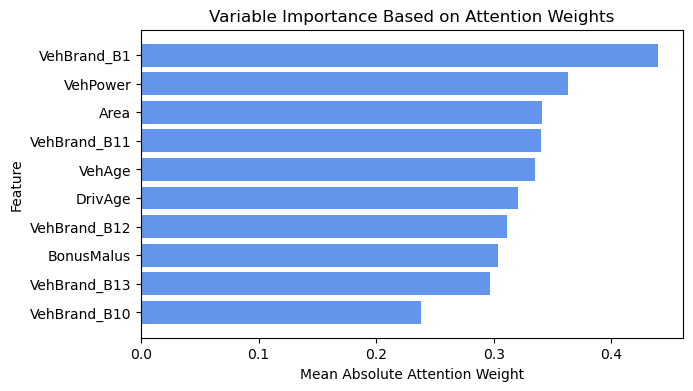

In [34]:
# Compute importance: mean absolute weight across all neurons in the attention layer
feature_importance = np.mean(np.abs(attention_weights), axis=1)

sorted_idx = np.argsort(feature_importance)[::-1] 
    
plt.figure(figsize=(7, 4))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx], color="cornflowerblue")
plt.xlabel("Mean Absolute Attention Weight")
plt.ylabel("Feature")
plt.title("Variable Importance Based on Attention Weights")
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance on top
plt.show()

To provide more insight and explainability, the attention weights can be used for local explanations. This means that for a specific data record, we can analyze the attention weights to inspect the contributions to the prediction for that specific record.

In [35]:
# Get the attention layer output model
attention_layer = localglm_model.get_layer("Attention")
attention_model = tf.keras.Model(inputs=localglm_model.input, outputs=attention_layer.output)

# Predict attention weights for the given sample
attention_values = attention_model.predict([X_test, np.ones((X_test.shape[0], 1))])

# Convert to DataFrame
explanations_df = pd.DataFrame(attention_values, columns=feature_names)

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [36]:
# Now create a function that will plot local attention weights for a given record
def plot_local_explanations(local_explanations, sample_ids):

    plt.figure(figsize=(10, len(sample_ids) * 0.5))
    sns.heatmap(local_explanations.loc[sample_ids], cmap="coolwarm", annot=False)
    plt.xlabel("Feature")
    plt.ylabel("Sample ID")
    plt.title("Local Attention Weights")
    plt.show()

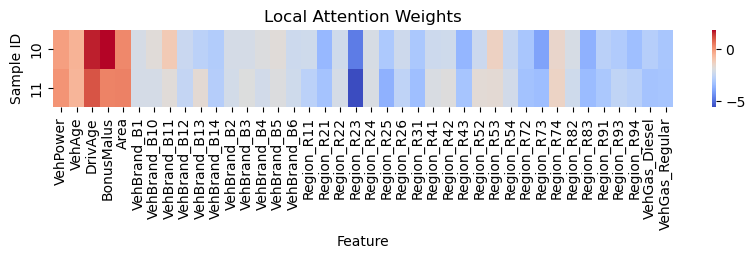

In [37]:
plot_local_explanations(explanations_df, sample_ids=[10, 11])

Finally, as we showed for the CANN model, we can assess predictions of the LocalGLMNet versus the benchmark GLM for each feature.

In [38]:
# We have defined a proper X_test for the CANN model, so now we only need to add the LocalGLMNet predictions
X_test_inv_df['LocalGLM_Predictions'] = localglm_preds_test

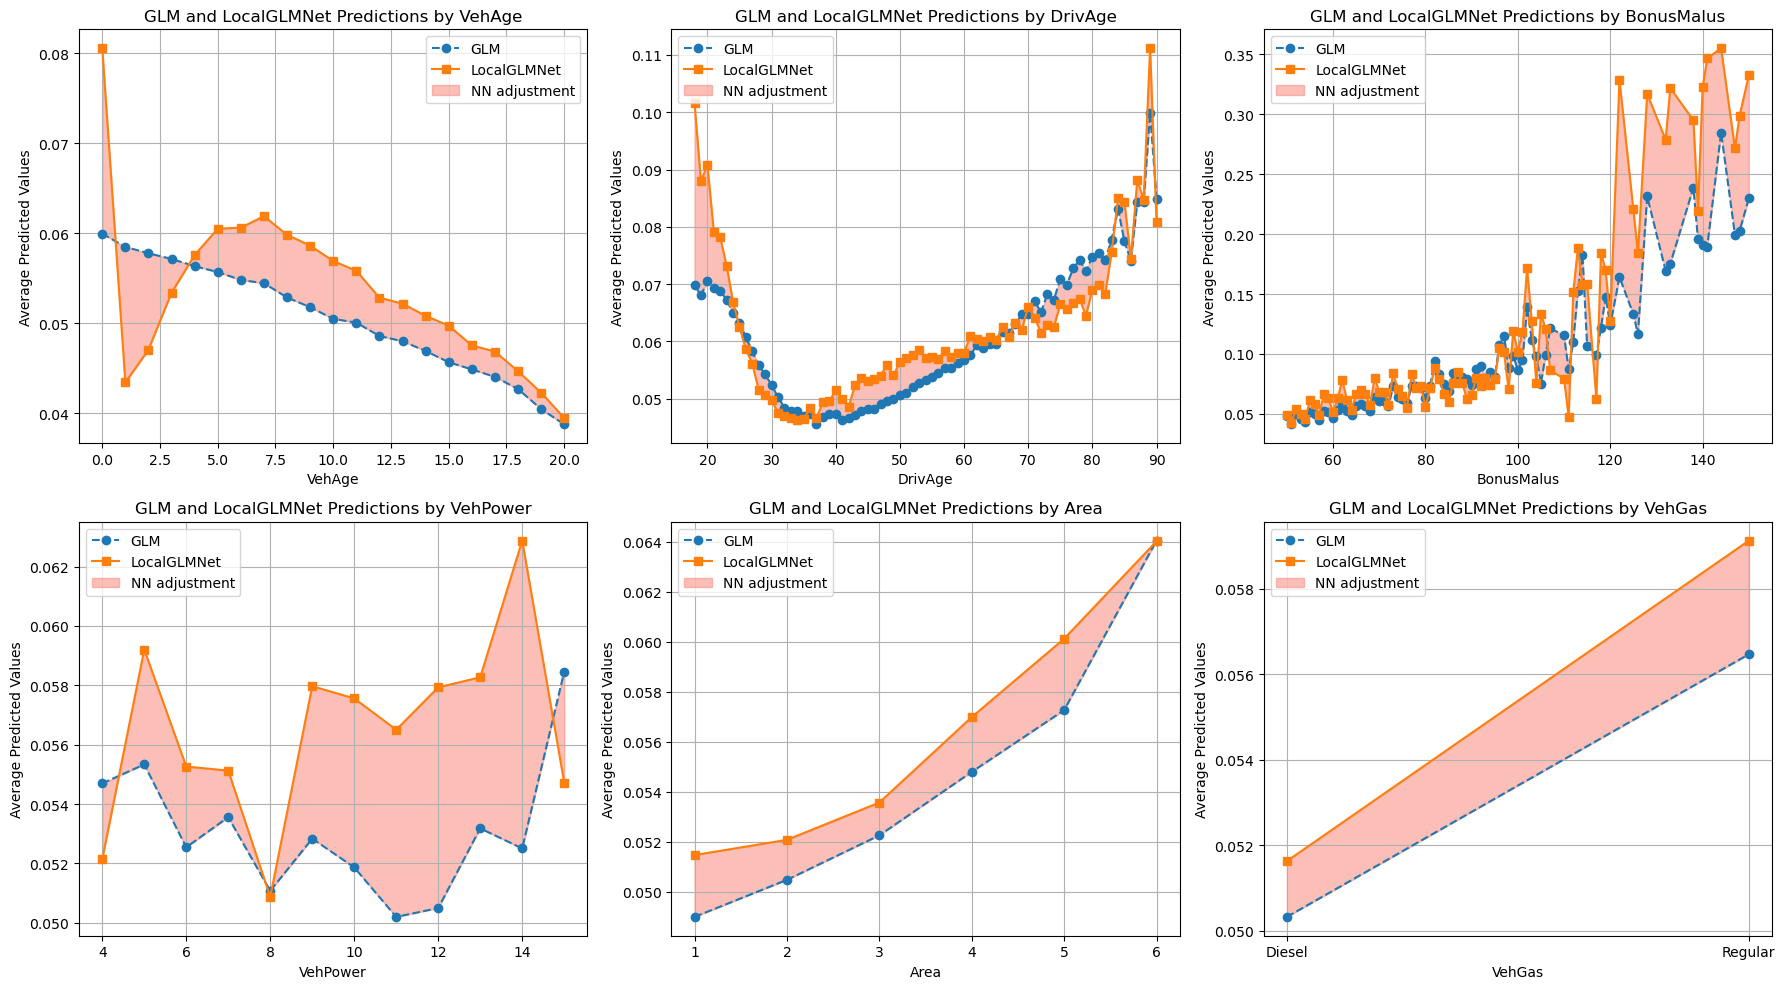

In [39]:
plot_feature_comparisons(['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas'], X_test_inv_df, 'GLM_Predictions', 'LocalGLM_Predictions', model1_label="GLM", model2_label="LocalGLMNet")

<a id="tabnet"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>TabNet</b></div>

TabNet intro.

The TabNet model has a more dense representation of the features, as opposed to sparse binary vectors which result from OneHot encoding. So instead of OneHot encoding, we apply Label Encoding to the categorical features. The preproccesing step is therefore adjusted:

In [13]:
# For this step, we use the X data as this set already includes some data preparation, but no encoding yet

# Drop the density feaature
X = X.drop(columns='Density')

# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store encoders if needed later

# Split the dataset including the exposure
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.1, random_state=42)

# Apply standard scaling to numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

TabNet does not have a build-in Poisson loss metric for evaluation. We will therefore train on RMSE. We can now initialize the TabNet model and start training it:

In [15]:
# Initialize TabNet
tabnet = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,  
    optimizer_params={"lr": 5e-5}, # Low learning rate to prevent overfitting
    lambda_sparse=0.001,  # Encourage sparsity in feature selection
    gamma=1.5,  # Increases feature reusability (higher values = less overfitting)
    n_steps=3,  # Number of steps in the architecture
)

# Train the TabNet model
tabnet.fit(X_train.values, y_train,
           eval_set=[(X_test.values, y_test)],
           eval_metric=['rmse'],  
           max_epochs=20,
           batch_size=256,  # Reduce batch size to prevent overfitting (512)
           virtual_batch_size=128,
           patience=5)

c:\Users\bart_\anaconda3\envs\dl-env\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.43393 | val_0_rmse: 0.32081 |  0:01:23s
epoch 1  | loss: 0.09469 | val_0_rmse: 0.26289 |  0:02:50s
epoch 2  | loss: 0.07299 | val_0_rmse: 0.24721 |  0:04:18s
epoch 3  | loss: 0.06626 | val_0_rmse: 0.24149 |  0:05:45s
epoch 4  | loss: 0.06315 | val_0_rmse: 0.23869 |  0:07:19s
epoch 5  | loss: 0.06159 | val_0_rmse: 0.23711 |  0:08:52s
epoch 6  | loss: 0.0607  | val_0_rmse: 0.23619 |  0:10:28s
epoch 7  | loss: 0.0601  | val_0_rmse: 0.23559 |  0:11:55s
epoch 8  | loss: 0.05967 | val_0_rmse: 0.23503 |  0:13:20s
epoch 9  | loss: 0.05936 | val_0_rmse: 0.2347  |  0:14:47s
epoch 10 | loss: 0.0591  | val_0_rmse: 0.23449 |  0:16:13s
epoch 11 | loss: 0.05897 | val_0_rmse: 0.2344  |  0:17:39s
epoch 12 | loss: 0.05886 | val_0_rmse: 0.23432 |  0:19:19s
epoch 13 | loss: 0.05877 | val_0_rmse: 0.23424 |  0:21:17s
epoch 14 | loss: 0.05867 | val_0_rmse: 0.23417 |  0:23:05s
epoch 15 | loss: 0.05862 | val_0_rmse: 0.23416 |  0:24:32s
epoch 16 | loss: 0.05856 | val_0_rmse: 0.23405 |  0:26:0

c:\Users\bart_\anaconda3\envs\dl-env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


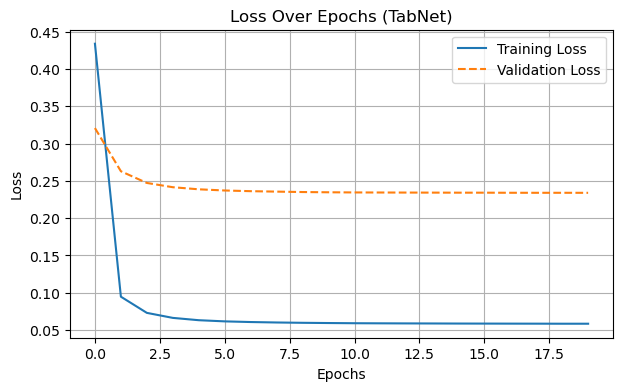

In [16]:
# Extract loss history from TabNet
train_losses = tabnet.history["loss"]
val_losses = tabnet.history["val_0_rmse"]

# Plot the loss over epochs
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.title('Loss Over Epochs (TabNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Evaluate TabNet
#tabnet_preds_test = np.exp(tabnet.predict(X_test.values))
tabnet_preds_test = np.clip(tabnet.predict(X_test.values), a_min=1e-6, a_max=None)
evaluate_model("TabNet", y_test, tabnet_preds_test)

TabNet - RMSE: 0.2340, MAE: 0.0967, Poisson Deviance: 0.3161


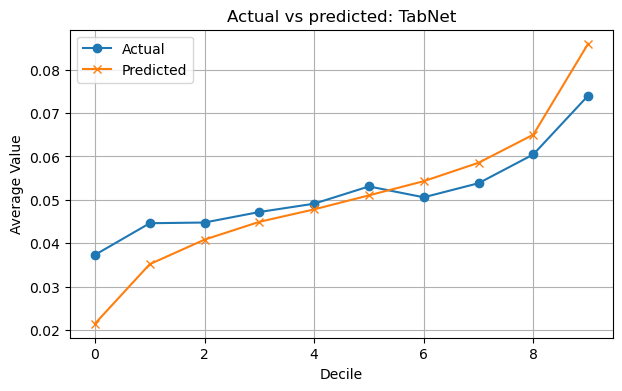

In [18]:
tabnet_preds_test = tabnet_preds_test.ravel()
y_test = y_test.ravel()
quantile_plot("TabNet",y_test, tabnet_preds_test)

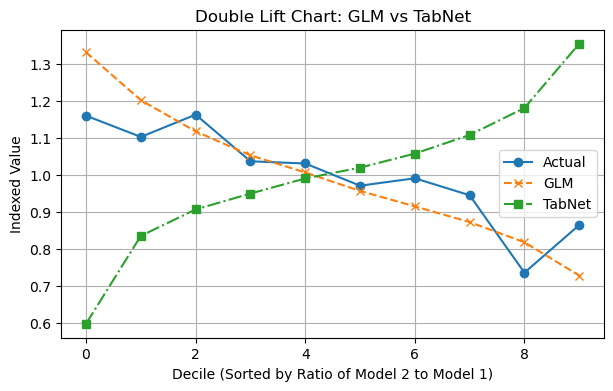

In [19]:
double_lift_chart("GLM", "TabNet", y_test, glm_preds_test, tabnet_preds_test, exposure_test, num_bins=10)

In [20]:
model_results

{'GLM': {'RMSE': 0.23345568582589418,
  'MAE': 0.09910314562407511,
  'Poisson Deviance': 0.3079645975560512},
 'TabNet': {'RMSE': 0.23396704441289773,
  'MAE': 0.09671869386215412,
  'Poisson Deviance': 0.3160591512381831}}

In [ ]:
TabNet decision masks!!

<a id="results"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Results evaluation</b></div>

In [ ]:
# compare KPIS
# compare feature importance

<a id="ref"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>References</b></div>

* Ronald Richman and Mario V. Wüthrich. 2023. LocalGLMnet: interpretable deep learning for tabular data. *Scandinavian Actuarial Journal* 2023(1), 71–95.

* Mario V. Wüthrich and Michael Merz. 2019. EDITORIAL: YES, WE CANN! *ASTIN Bulletin* 49(1), 1-3.

* Mario V. Wüthrich and Michael Merz. 2023. Statistical Foundations of Actuarial Learning and its Applications. Springer (open access), https://link.springer.com/book/10.1007/978-3-031-12409-9

* Sercan Arik and Tomas Pfister. 2021. TabNet: Attentive Interpretable Tabular Learning. In The Thirty-Fifth AAAI Conference on Artificial Intelligence (AAAI-21). 6679–6687.

* Kevin McDonnell, Finbarr Murphy, Barry Sheehan, Leandro Masello, and German Castignani. 2023. Deep learning in insurance: Accuracy and model interpretability using TabNet. Expert Systems with Applications 217 (5 2023), 119543.

<a id="rel"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Related Projects</b></div>

For example implementation of CANN, please see:

* https://github.com/freekholvoet/nnforfreqsevpricing
* https://www.kaggle.com/code/floser/use-case-claim-frequency-modeling-python

For example implementation of LocalGLMNet, please see:

* https://github.com/neeland/local-glm-net/tree/main/local-glm-net

For example implementation of TabNet, please see:

* https://www.kaggle.com/code/carlmcbrideellis/tabnet-a-very-simple-regression-example